## LRF with RRTMG

### Import packages

In [1]:
import sys;
import json;
import h5py;
import numpy as np;
import netCDF4 as nc;
import climlab as cl;

import metpy.calc as mpcalc
from metpy.units import units

from copy import deepcopy;
from matplotlib import pyplot as plt;

sys.path.append("/home/b11209013/Package/"); # path to my packages
import Plot_Style as ps;

### Construct RRTMG

In [2]:
# constructing RRTMG
levs = np.linspace(100.0, 1000.0, 37)
lev_lim = np.argmin(np.abs(levs-300.0))

nlev = len(levs)

state = cl.column_state(num_lev=nlev, water_depth=1)

# water vapor profile
h2o = cl.radiation.ManabeWaterVapor(
    state=state,
    relative_humidity=0.77,   # surface RH (tunable)
    qStrat=5e-6               # minimum stratospheric q [kg/kg] ~ 0.005 g/kg
)

rad_model = cl.radiation.RRTMG(
    name="Radiation Model",
    state=state,
    specific_humidity=h2o.q,
    albedo=0.3,
);

rad_model.compute_diagnostics();

LW_ref = rad_model.diagnostics["TdotLW"].copy();
SW_ref = rad_model.diagnostics["TdotSW"].copy();

### perturb moisture and temperature

In [3]:
LRF = {
    "q_lw": np.zeros((nlev, nlev)),
    "q_sw": np.zeros((nlev, nlev)),
    "t_lw": np.zeros((nlev, nlev)),
    "t_sw": np.zeros((nlev, nlev)),
    }

for l in range(nlev):
    q_perturb = deepcopy(h2o.q);
    pert = q_perturb[l]*0.01
    q_perturb[l] += pert; # perturb specific humidity by 0.01 kg/kg

    rad_perturb = cl.radiation.RRTMG(
        name="Radiation Model",
        state=state,
        specific_humidity=q_perturb,
        albedo=0.3,
    );

    rad_perturb.compute_diagnostics();

    LRF["q_lw"][l] = (rad_perturb.diagnostics["TdotLW"] - LW_ref) / pert*1e-3;
    LRF["q_sw"][l] = (rad_perturb.diagnostics["TdotSW"] - SW_ref) / pert*1e-3;

    del q_perturb, rad_perturb;

for l in range(nlev):
    perturb_state = deepcopy(state);
    perturb_state["Tatm"][l] += 1;
    perturb_state["Ts"][:] = perturb_state["Tatm"][-1];

    rad_perturb = cl.radiation.RRTMG(
        name="Radiation Model",
        state=perturb_state,
        specific_humidity=h2o.q,
        albedo=0.3,
    );

    rad_perturb.compute_diagnostics();

    LRF["t_lw"][l] = (rad_perturb.diagnostics["TdotLW"] - LW_ref) / 1;
    LRF["t_sw"][l] = (rad_perturb.diagnostics["TdotSW"] - SW_ref) / 1;

    del perturb_state, rad_perturb;

### Plot out profile

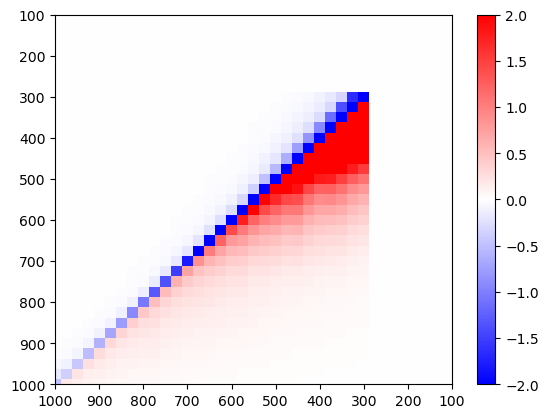

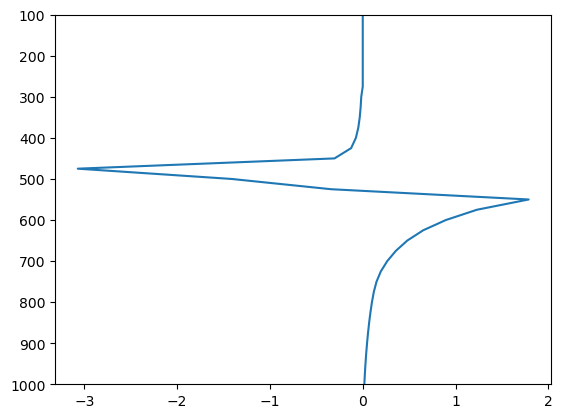

In [4]:
for key in LRF.keys():
    temp_resp = np.zeros((nlev, nlev));

    temp_resp[lev_lim:, lev_lim:] = LRF[key][lev_lim:, lev_lim:];
    LRF[key] = temp_resp;

plt.pcolormesh(levs,levs,LRF["q_lw"].T, vmin=-2, vmax=2, cmap='bwr');
plt.xlim(1000,100)
plt.ylim(1000,100)
plt.colorbar()
plt.show()

lev_500 = np.argmin(np.abs(levs-500.0))
mid_q_lw = LRF["q_lw"][lev_500-1:lev_500+2, :].mean(axis=0)

plt.plot(mid_q_lw, levs)
plt.ylim(1000,100)
plt.show()

### Regress coefficient of first two mode

[-0.67466859  3.57032084]


/tmp/ipykernel_3022257/3698831940.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  z_std = np.array(mpcalc.pressure_to_height_std(levs*units.hPa))*1000;


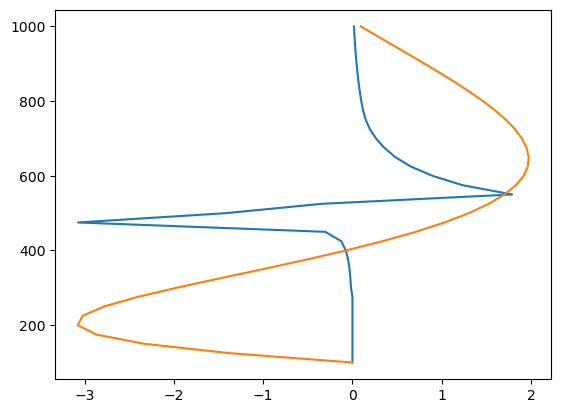

In [28]:
z_std = np.array(mpcalc.pressure_to_height_std(levs*units.hPa))*1000;
G1 = np.pi/2 * np.sin(np.pi*(z_std)/z_std[0]);
G2 = np.pi/2 * np.sin(2*np.pi*(z_std)/z_std[0]);

A = np.vstack([G1, G2]).T

coeff = np.array(mid_q_lw) @ np.array(A)

plt.plot(mid_q_lw, levs, label='RRTMG')
plt.plot(G1*(-0.5)+G2*1.6, levs, label='1st mode')
print(coeff)